# Anomaly Detection on Washer Data Set Using Multi-Res-U-Net.

# Multi-Res-U-Netを用いたWasherデータセットの異常検知。

# Import Necessary Packages.

# 必要なパッケージをインポートします。

In [4]:

import os
import PIL
from PIL import ImageOps
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import load_img

In [5]:
import tensorflow as tf
print(tf.__version__)

2.1.0


# Define Data Directory.

# データディレクトリの定義。

In [6]:
washer_ok_img = os.listdir("washer/washer_ok")
washer_ng_img = os.listdir("washer/washer_ng/kizu")
washer_test_img = os.listdir("washer/washer_ng/sabi")

# Set Up Training Data Path.

# トレーニングデータのパスを設定します。

In [7]:
train_path = []

for  ok_img in washer_ok_img[:30] :
    train_path.append('washer/washer_ok/'+ok_img)
    

print(len(train_path))

30


# Set Up Validation Data Path.

# バリデーションデータのパスを設定します。

In [8]:
valid_path = []

for ng_img in washer_ng_img[:10]:
    valid_path.append('washer/washer_ng/kizu/'+ng_img)
    
print(len(valid_path))

10


# Set Up Test Data Path.

# テストデータのパスの設定します。

In [9]:
test_path = []

for test_img in washer_test_img:
    test_path.append('washer/washer_ng/sabi/'+test_img)

print(len(test_path))

4


# Define: Image Size, Batch Size, Number of Classes.

# 定義します: 画像サイズ、バッチサイズ、クラスの数。

In [10]:
img_size = (160, 160)
num_classes = 2
batch_size = 1

# Prepare Sequence Class to Load and Vectorize Batches of Data.

# データのバッチをロードしてベクター化するためのシーケンスクラスを用意すします。

In [11]:
class Washer(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        #pass
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Return input correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]

        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x, y

# Implement Multi-Res-U-Net Model.

# Multi-Res-U-Net モデルの実装。

In [12]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(img_size,num_classes):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = keras.Input(shape=img_size + (3,))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, num_classes, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

# Multi-Res-U-Net Model Architecture.

# Multi-Res-U-Net モデルのアーキテクチャ。

In [13]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = MultiResUnet(img_size,num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 8)  216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 160, 8)  24          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 160, 160, 8)  0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

# Instantiate Data Sequences .

# データシーケンスのインスタンス化 。

In [14]:
# Instantiate data Sequences for each split
train_gen = Washer(batch_size, img_size, train_path)
val_gen = Washer(batch_size, img_size, valid_path)
test_gen = Washer(batch_size, img_size, test_path)

# Train Multi-Res-U-Net Model.

# Multi-Res-U-Net モデルの学習。

In [15]:
# Configure the model for training.
model.compile(optimizer="adam", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("washer_segmentation1.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30 steps, validate for 10 steps
Epoch 1/10
30/30 [==============================] - 60s 2s/step - loss: 144.7270 - val_loss: 132.7616
Epoch 2/10
30/30 [==============================] - 40s 1s/step - loss: 144.2788 - val_loss: 132.7623
Epoch 3/10
30/30 [==============================] - 39s 1s/step - loss: 144.2738 - val_loss: 132.7733
Epoch 4/10
30/30 [==============================] - 39s 1s/step - loss: 144.2720 - val_loss: 132.7790
Epoch 5/10
30/30 [==============================] - 39s 1s/step - loss: 144.2709 - val_loss: 132.7725
Epoch 6/10
30/30 [==============================] - 39s 1s/step - loss: 144.2702 - val_loss: 132.7689
Epoch 7/10
30/30 [==============================] - 39s 1s/step - loss: 144.2697 - val_loss: 132.7668
Epoch 8/10
30/30 [==============================] - 39s 1s/step - loss: 144.2693 - val_loss: 132.7656
Epoch 9/10
30/30 [==============================] - 37s 1s/step - loss: 144.2691 - val_loss:

# Loss and Validation Loss Curve.

# 損失とバリデーションの損失曲線.

<AxesSubplot:>

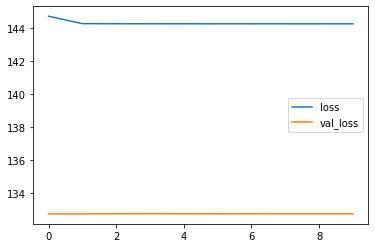

In [16]:
import pandas as pd
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

# Prediction for Images in Test Data Set.

# テストデータセットに含まれる画像の予測値です。

In [17]:
# Generate predictions for all images in the test set.
test_gen = Washer(1, img_size, test_path)
test_preds = model.predict(test_gen)

# Inference Test Data with Heat Map.

# ヒートマップによる推論テストデータ。

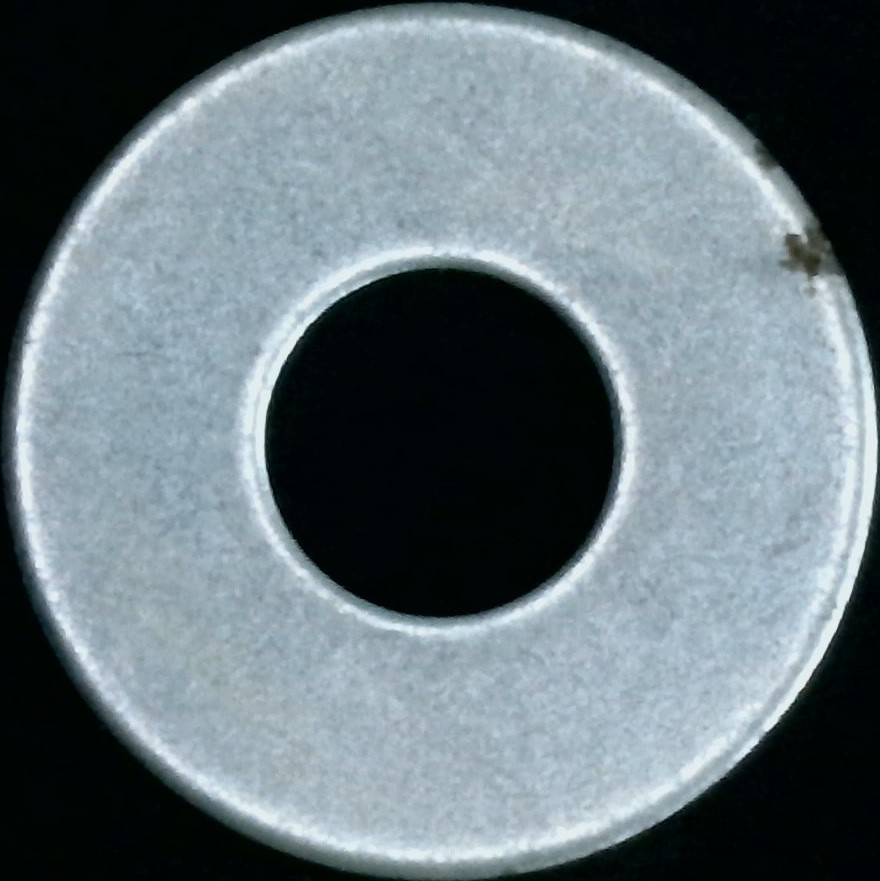

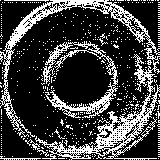

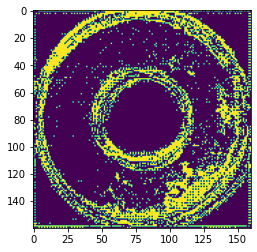

In [18]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    plt.imshow(mask)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for test image
i = 3

# Display input image
display(Image(filename=test_path[i], width=256, height=256))


# Display mask predicted by our model
display_mask(i) 